In [60]:
import pandas as pd
import re
from glob import glob
import os
from matplotlib import pyplot as plt
import itertools

In [27]:
def get_num(string):
    m = re.search(r"\b(\d+)(?=-)", string)
    return int(m.group()) if m else None

def assign_condition(sheet_name):
    # Check if Pre-dev
    if re.search(r"(\bPre-)", sheet_name, flags=re.IGNORECASE):
        return 'PRE'
    elif re.search(r"(\bPost-)", sheet_name, flags=re.IGNORECASE):
        return 'POST'
    else:
        return 'NO FLOW CONDITION APPLIES'

def assign_value_name(sheet_name):
    prefix = re.split(r'\b(?:Pre|Post)-', sheet_name, flags=re.IGNORECASE)[0].strip()
    return prefix

In [40]:
# Define paths
xl_path = r"C:\Users\richmond\AMH Philippines, Inc\PP23.307 Rockwell and Roll - My Documents\Python\amh_pyqgis\flow_extraction\Validation\Sipit Validation\(HH-CALC) HEC-RAS Results Creek 4 R0 2025.01.27.xlsm"
sheet_list = [ 'Discharge Pre-dev-', 'Velocity Pre-dev', 'Froude Number Pre-dev', 'WSE Pre-dev', 'EGE Pre-dev',
            'Discharge Post-dev-', 'Velocity Post-dev', 'Froude Number Post-dev', 'WSE Post-dev', 'EGE Post-dev']

# Read Excel using pandas
with pd.ExcelFile(xl_path) as xl:
    df = pd.read_excel(xl, 
                       sheet_name=sheet_list,
                       skiprows=1,
                       usecols='A:E',
                       nrows=15
                       )

In [41]:
centerline_string = 'C4 - Sta 0+'
url = r"C:\Users\richmond\AMH Philippines, Inc\PP23.307 Rockwell and Roll - My Documents\Python\amh_pyqgis\flow_extraction\Validation"
csv_save = os.path.join(url, 'c4.csv')

In [42]:
# ---- For Pre-Dev ----
df2 = df[sheet_list[0]].copy()
# Set a Station Name
df2['Station'] = df2.apply(lambda x: f'{centerline_string}{x['Stations']:.0f}', axis=1)
# Pivot RP Columns
df2 = df2.melt(
    id_vars=['Stations', 'Station'],
    value_vars=  ['15-yr', '25-yr', '50-yr', '100-yr'], 
    var_name = 'Flow Scenario',
    value_name = assign_value_name(sheet_list[0])
    )
df2['Flow Scenario'] = df2['Flow Scenario'].apply(lambda x: str(get_num(x)) + 'YR ' + assign_condition(sheet_list[0]))

for sheet in sheet_list[:5]:
    # Copy current DataFrame in df1 variable
    df1 = df[sheet].copy()
    # Set a Station Name
    df1['Station'] = df1.apply(lambda x: f'{centerline_string}{x['Stations']:.0f}', axis=1)
    # Pivot RP Columns
    df1 = df1.melt(
        id_vars=['Stations', 'Station'],
        value_vars=  ['15-yr', '25-yr', '50-yr', '100-yr'], 
        var_name = 'Flow Scenario',
        value_name = assign_value_name(sheet)
        )
    df1['Flow Scenario'] = df1['Flow Scenario'].apply(lambda x: str(get_num(x)) + 'YR ' + assign_condition(sheet))

    df2[f'{assign_value_name(sheet)}'] = df1[f'{assign_value_name(sheet)}']



# ---- For Post-Dev ----
df3 = df[sheet_list[5]].copy()
# Set a Station Name
df3['Station'] = df3.apply(lambda x: f'{centerline_string}{x['Stations']:.0f}', axis=1)
# Pivot RP Columns
df3 = df3.melt(
    id_vars=['Stations', 'Station'],
    value_vars=  ['15-yr', '25-yr', '50-yr', '100-yr'], 
    var_name = 'Flow Scenario',
    value_name = assign_value_name(sheet_list[5])
    )
df3['Flow Scenario'] = df3['Flow Scenario'].apply(lambda x: str(get_num(x)) + 'YR ' + assign_condition(sheet_list[5]))

# Loop
for sheet in sheet_list[6:]:
    # Copy current DataFrame in df1 variable
    df1 = df[sheet].copy()
    # Set a Station Name
    df1['Station'] = df1.apply(lambda x: f'{centerline_string}{x['Stations']}', axis=1)
    # Pivot RP Columns
    df1 = df1.melt(
        id_vars=['Stations', 'Station'],
        value_vars=  ['15-yr', '25-yr', '50-yr', '100-yr'], 
        var_name = 'Flow Scenario',
        value_name = assign_value_name(sheet)
        )
    df1['Flow Scenario'] = df1['Flow Scenario'].apply(lambda x: str(get_num(x)) + 'YR ' + assign_condition(sheet))

    df3[f'{assign_value_name(sheet)}'] = df1[f'{assign_value_name(sheet)}']

# Combine both DataFrame
df_concat = pd.concat([df2, df3]).reset_index().drop(columns=['index'])
# Save the Concat CSV
df_concat.to_csv(csv_save, index=False)


In [47]:
x = os.path.join(url, '*.csv')
csv_paths = glob(x)
csv_save = os.path.join(url, 'combined.csv')

df_combined = pd.concat([pd.read_csv(path) for path in csv_paths], ignore_index=True)
df_combined.to_csv(csv_save, index=False)

In [72]:
results_csv = r"C:\Users\richmond\AMH Philippines, Inc\PP23.307 Rockwell and Roll - My Documents\Python\amh_pyqgis\flow_extraction\Sipit_RAS\results\res9.csv"
combined_csv = r"C:\Users\richmond\AMH Philippines, Inc\PP23.307 Rockwell and Roll - My Documents\Python\amh_pyqgis\flow_extraction\Validation\combined.csv"

df_res9 = pd.read_csv(results_csv)
df_combined = pd.read_csv(combined_csv)


df_res9['station_index'] = df_res9['Station'].str.extract(r'0\+(\d+(?:\.\d+)?)')[0].astype(float)
df_res9['station_group'] = df_res9['Station'].str.extract(r'^(Sta|C2|C3|C4)', expand=False)

df_combined['station_group'] = df_combined['Station'].str.extract(r'^(Sta|C2|C3|C4)', expand=False)

numeric_df = df_res9.select_dtypes(include='number').columns
flow_scenarios = df_res9['Flow Scenario'].unique()

In [45]:
df_res9.head(5)

,Plan ShortID,Station,Flow Scenario,Discharge,AveWSE,Thalweg,MaxVelocity,MaxFroude,MaxEGL,CL-WSE,CL-Velocity,CL-Froude,CL-EGL,station_index,station_group
0,15YR PRE R3,Sta 0+200,15YR PRE,40.222,74.162,71.992,2.326,0.982,2.449,74.406,1.586,0.307,1.490,200.0,Sta
1,15YR PRE R3,Sta 0+160 (1),15YR PRE,40.432,70.580,69.000,5.342,12.728,5.579,70.567,5.342,1.476,5.332,160.0,Sta
2,15YR PRE R3,Sta 0+100,15YR PRE,40.664,65.929,65.070,5.113,15.734,5.018,66.645,3.915,1.272,3.833,100.0,Sta
3,15YR PRE R3,Sta 0+80,15YR PRE,43.666,66.368,63.992,2.151,1.639,2.155,66.562,2.008,0.466,2.035,80.0,Sta
4,15YR PRE R3,Sta 0+60,15YR PRE,43.617,65.472,63.102,6.070,3.333,5.598,65.473,5.516,2.079,5.205,60.0,Sta


In [46]:
df_combined.head(5)

,Stations,Station,Flow Scenario,Discharge,Velocity,Froude Number,WSE,EGE,station_group
0,0,Sta 0+0,15YR PRE,0.000,0.000,0.000,0.000,0.000,Sta
1,20,Sta 0+20,15YR PRE,43.803,2.455,0.382,63.581,63.873,Sta
2,40,Sta 0+40,15YR PRE,43.661,3.587,0.628,64.486,65.050,Sta
3,60,Sta 0+60,15YR PRE,45.499,5.299,1.225,65.492,66.784,Sta
4,80,Sta 0+80,15YR PRE,43.597,2.086,0.436,66.555,66.775,Sta


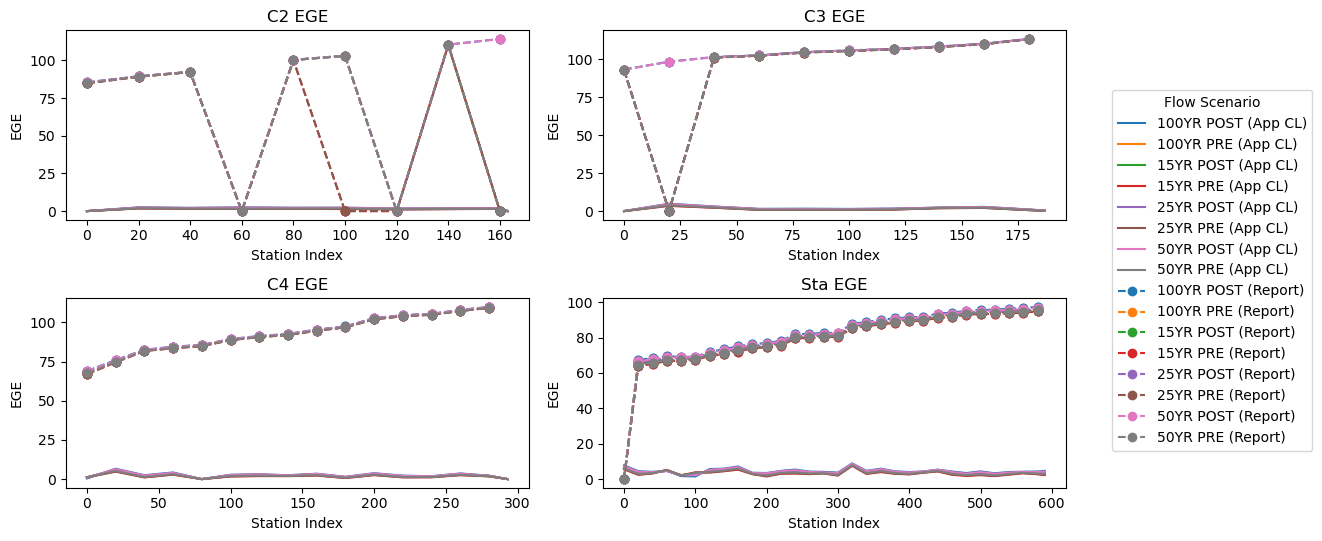

In [84]:
# Plot the Flow Extract App Results
fig, axes = plt.subplots(figsize=(11.81, 5.51), nrows=2, ncols=2)
axes = axes.flatten()

res9_groups = df_res9.groupby(['station_group', 'Flow Scenario'])
combined_group = df_combined.groupby(['station_group', 'Flow Scenario'])

subplot_map = {}
subplot_index = 0

legend_dict = {}

# Define a color cycle for consistent hues
colors = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

color_map = {}  # To assign same base color for same flow_scenario

# --- App Results  Reference Line---
# for (group_name, flow_scenario), group in res9_groups:
#     if group_name not in subplot_map:
#         subplot_map[group_name] = axes[subplot_index]
#         subplot_index += 1

#     ax = subplot_map[group_name]
#     group = group.sort_values('station_index')

#     # Get or assign base color for this flow_scenario
#     if flow_scenario not in color_map:
#         color_map[flow_scenario] = next(colors)
#     color = color_map[flow_scenario]

#     # Plot App result
#     line, = ax.plot(group['station_index'], group['MaxEGL'], label=f'{flow_scenario} (App Max)', color=color)

#     ax.set_title(f'{group_name} EGL')
#     ax.set_xlabel('Station Index')
#     ax.set_ylabel('EGL')

#     legend_dict[f'{flow_scenario} (App FML)'] = line


# --- App Results CenterLine (CL) Sampled---
for (group_name, flow_scenario), group in res9_groups:
    if group_name not in subplot_map:
        subplot_map[group_name] = axes[subplot_index]
        subplot_index += 1

    ax = subplot_map[group_name]
    group = group.sort_values('station_index')

    # Get or assign base color for this flow_scenario
    if flow_scenario not in color_map:
        color_map[flow_scenario] = next(colors)
    color = color_map[flow_scenario]

    # Plot App result
    line, = ax.plot(group['station_index'], group['CL-EGL'], label=f'{flow_scenario} (App CL)', color=color)

    ax.set_title(f'{group_name} EGL')
    ax.set_xlabel('Station Index')
    ax.set_ylabel('EGL')

    legend_dict[f'{flow_scenario} (App CL)'] = line




# --- Report Results ---
for (group_name, flow_scenario), group in combined_group:
    if group_name not in subplot_map:
        subplot_map[group_name] = axes[subplot_index]
        subplot_index += 1

    ax = subplot_map[group_name]
    group = group.sort_values('Stations')

    # Use same base color, different style
    color = color_map.get(flow_scenario, next(colors))

    # Plot Report result with marker
    line, = ax.plot(group['Stations'], group['EGE'], label=f'{flow_scenario} (Report)',
                    color=color, linestyle='--', marker='o')

    ax.set_title(f'{group_name} EGE')
    ax.set_xlabel('Station Index')
    ax.set_ylabel('EGE')

    legend_dict[f'{flow_scenario} (Report)'] = line

# Remove unused subplots
for i in range(subplot_index, len(axes)):
    fig.delaxes(axes[i])

# Global legend
fig.legend(
    handles=list(legend_dict.values()),
    labels=list(legend_dict.keys()),
    loc='center left',
    bbox_to_anchor=(0.94, 0.5),  # Pull legend closer
    title='Flow Scenario'
)

plt.tight_layout(rect=[0, 0, 0.92, 1])  # Reduce space reserved for legend
plt.show()